In [1]:
using VRPLIB, JuMP, Gurobi, Random, Distributions,LightGraphs, GraphPlot, MetaGraphs, GraphRecipes, Plots,Graphs


(process:5632): GLib-GIO-WARNING **: 12:51:58.148: Unexpectedly, UWP app `38526MediaLife.ZipPlus_2.0.4.0_x86__1crh1k73ty8mg' (AUMId `38526MediaLife.ZipPlus_1crh1k73ty8mg!ZipExtractor') supports 89 extensions but has no verbs


In [2]:
instance = readTSP("D:/Documentos/PUC/Mestrado/2021.2/Optimization Under Uncertainty/project_definition/Vrp-Set-P/P/P-n16-k8.vrp")
nodes = collect(1:instance.dimension)
K=8

8

In [3]:
# model = Model(GLPK.Optimizer)
# # set_optimizer_attribute(model, "LogLevel",0)

# @variables(model,
# begin
#     x[nodes,nodes,1:K], Bin
#     u[nodes[2:end]] ≥ 0
# end)

# @constraints(model,
#     begin
#         ct1[j in nodes[2:end], k in 1:K], sum(x[i,j,k] for i in nodes) == sum(x[j,i,k] for i in nodes)
#         ct2[j in nodes[2:end]], sum(x[i,j,k] for i in nodes for k in 1:K) == 1
#         ct3[k in 1:K], sum(x[1,j,k] for j in nodes[2:end]) == 1
#         ct4[k in 1:K], sum(demand[j]*x[i,j,k] for i in nodes for j in nodes[2:end]) ≤ C
#         ct5[k in 1:K,i in nodes[2:end], j in nodes[2:end]; i != j], u[j] - u[i] ≥ demand[j]- C*(1-x[i,j,k])
#         ct6[i in nodes[2:end]], demand[i] ≤ u[i] ≤ C
#         ct7[i in nodes, k in 1:K], x[i,i,k] == 0
#     end)

# @objective(model, Min, sum(instance.weights[i,j] * x[i,j,k] for i in nodes for j in nodes for k in 1:K))
# set_optimizer_attribute(model, "tm_lim", 3600*1_000)
# set_optimizer_attribute(model, "msg_lev", GLPK.GLP_MSG_ON)
# optimize!(model)
# objective_value(model)

## DETERMINISTIC FORMULATION

In [4]:
model_deterministic = Model(Gurobi.Optimizer)
# set_optimizer_attribute(model, "LogLevel",0)

@variables(model_deterministic,
begin
    x[nodes,nodes], Bin
    u[nodes[2:end]] ≥ 0
end)

@constraints(model_deterministic,
    begin
        ct1[j in nodes[2:end]], sum(x[i,j] for i in nodes) == 1
        ct2[i in nodes[2:end]], sum(x[i,j] for j in nodes) == 1
        ct3, sum(x[i,1] for i in nodes) == K
        ct4, sum(x[1,j] for j in nodes) == K
        ct5[i in nodes[2:end], j in nodes[2:end]; i != j], u[j] - u[i] + instance.capacity*(1-x[i,j]) ≥ instance.demand[j]
        ct6[i in nodes[2:end]], instance.demand[i] ≤ u[i] ≤ instance.capacity
        ct7[i in nodes], x[i,i] == 0
    end)

@objective(model_deterministic, Min, sum(instance.weights[i,j] * x[i,j] for i in nodes for j in nodes))
set_optimizer_attribute(model_deterministic, "TimeLimit", 900)
optimize!(model_deterministic)

println(objective_value(model_deterministic))
for i in nodes
    for j in nodes
        if(value.(x)[CartesianIndex(i,j)]==1)
            println("x[$i,$j] = $(value.(x)[CartesianIndex(i,j)])")
        end
    end
end

Academic license - for non-commercial use only - expires 2022-01-10
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 273 rows, 286 columns and 1188 nonzeros
Model fingerprint: 0xc76bccfe
Variable types: 30 continuous, 256 integer (256 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [6e+00, 5e+01]
  Bounds range     [6e+00, 4e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 121 rows and 123 columns
Presolve time: 0.01s
Presolved: 152 rows, 163 columns, 1346 nonzeros
Variable types: 13 continuous, 150 integer (150 binary)
Found heuristic solution: objective 538.0000000

Root relaxation: objective 4.051429e+02, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  405.14286    0   23  538.00000  405.14286 

## ROBUST FORMULATION

In [5]:
# Generate Uniform Random demands
seed = 8748748
rng = MersenneTwister(seed)

demand_variation_5_perc = rand(rng,Uniform(-0.05,0.05),instance.dimension,5)
demand_scenarios_5_perc =  ceil.(demand_variation_5_perc.*instance.demand); #[node,scenario]

# Model
model2 = Model(Gurobi.Optimizer)
# set_optimizer_attribute(model, "LogLevel",0)

@variables(model2,
begin
    x[nodes,nodes], Bin
    u[nodes[2:end]] ≥ 0
end)

@constraints(model2,
    begin
        ct1[j in nodes[2:end]], sum(x[i,j] for i in nodes) == 1
        ct2[i in nodes[2:end]], sum(x[i,j] for j in nodes) == 1
        ct3, sum(x[i,1] for i in nodes) == K
        ct4, sum(x[1,j] for j in nodes) == K
        ct5[i in nodes[2:end], j in nodes[2:end]; i != j], u[j] - u[i] + instance.capacity*(1-x[i,j]) ≥ instance.demand[j] + maximum([maximum(demand_scenarios_5_perc[j,:]),0])
        ct6[i in nodes[2:end]], 0 ≤ u[i] ≤ instance.capacity
        ct7[i in nodes], x[i,i] == 0
    end)

@objective(model2, Min, sum(instance.weights[i,j] * x[i,j] for i in nodes for j in nodes))
set_optimizer_attribute(model2, "TimeLimit", 3600)
optimize!(model2)
obj_value = objective_value(model2)
println(obj_value)
# for i in nodes
#     for j in nodes
#         if(value.(x)[CartesianIndex(i,j)]==1)
#             println("x[$i,$j] = $(value.(x)[CartesianIndex(i,j)])")
#         end
#     end
# end

Academic license - for non-commercial use only - expires 2022-01-10
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 273 rows, 286 columns and 1188 nonzeros
Model fingerprint: 0x235f1ff0
Variable types: 30 continuous, 256 integer (256 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [6e+00, 5e+01]
  Bounds range     [4e+01, 4e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 37 rows and 139 columns
Presolve time: 0.01s
Presolved: 236 rows, 147 columns, 1585 nonzeros
Variable types: 15 continuous, 132 integer (132 binary)

Root relaxation: objective 4.092772e+02, 65 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  409.27725    0   20          -  409.27725      -     -    0s
     0     0  413.22236    0  

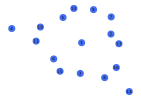

In [6]:
x_matrix = zeros(Int64, instance.dimension, instance.dimension)
for i in nodes
    for j in nodes
        x_matrix[i,j] = value.(x)[CartesianIndex(i,j)]
    end
end
nodelabel = 1:instance.dimension
a = Graphs.SimpleGraphs.SimpleDiGraph(x_matrix)

gplot(a, nodelabel = nodelabel,nodefillc=colorant"royalblue2",
    edgestrokec=colorant"gray20",edgelinewidth=0,arrowlengthfrac=0.05)

In [7]:
# Generate Normal Random demands
seed = 7623672
rng = MersenneTwister(seed)
simulated_demand = ceil.(rand(rng,Normal(mean(instance.demand), std(instance.demand)),instance.dimension,1000))

comparison_dict = Dict{Int64, Vector}()
comparison_sup_list = []
comparison_inf_list = []
comparison_eq_list = []
num_scenarios = 5
count_inf = 0
count_equal = 0
count_sup = 0

for i in 1:1:1000
    simulated_return = sum(x_list.*simulated_demand[:,i])
    if(simulated_return < obj_value)
        count_inf += 1
    elseif (simulated_return == obj_value)
        count_equal += 1
    else
        count_sup += 1
    end 
end

push!(comparison_dict, num_scenarios => [count_inf/1000, count_equal/1000, count_sup/1000])
append!(comparison_sup_list,count_sup/1000)
append!(comparison_eq_list,count_equal/1000)
append!(comparison_inf_list,count_inf/1000)

print(sort(comparison_dict))
# ticklabel = string.(collect(1:9))
# groupedbar([comparison_sup_list comparison_eq_list comparison_inf_list],
#         bar_position = :stack,
#         bar_width=0.7,
#         xticks=(1:9, ticklabel),
#         label=["Simulated > Optimal" "Simulated = Optimal" "Simulated < Optimal"],
#         title = "Comparison Simulated vs Optimal returns",
#         xlabel = "Gamma",
#         ylabel = "Comparison over categories",
#         legend=:outertopright,
#         legendfontsize=12)
# Conforme eu vou aumentando o Γ menos casos tem que eu perco mais dinheiro do que o robusto previu (sim<opt)

LoadError: UndefVarError: x_list not defined